# Modelo basado en agentes para la Asignacion de pacientes en sala de hospitalizaciones
**Autores:** Ana Sofía Gutiérrez, Salomón Cardeño, Isabella Quintero

In [24]:
# importar librerias
import numpy as np
import matplotlib.pyplot as plt
from functools import partial 

class Game:
    ''' Clase que define el juego de las enfermeras
    Parametros:
        n_patients: numero de pacientes que llegan al hospital
        n_enf: numero de enfermeras
        p_short_stay: probabilidad de que un paciente sea de corta estancia
        arrival_rate: tasa de llegada de pacientes al hospital
    '''
    def __init__ (self, n_patients, n_enf, p_short_stay, arrival_rate):
        self.n_patients=n_patients
        self.n_enf=n_enf
        self.p_short_stay=p_short_stay
        self.arrival_rate=arrival_rate
        self.reset_patients()
        self.experience_weight=np.arange(1,self.n_enf+1)/10
        
    def reset_patients (self):
        ''' Funcion que genera los pacientes que llegan al hospital'''
        stay_length=lambda kind: 1 if kind=='short' else 2
        self.patient_kind_stay=np.random.choice(['short','long'],p=[self.p_short_stay,1-self.p_short_stay],size=self.n_patients)
        self.patient_entry = np.random.exponential(scale=self.arrival_rate,size=(self.n_patients)).astype(int)
        self.patient_entry.sort()
        self.patient_entry+=np.arange(self.n_patients)-self.patient_entry.min()
        self.patient_stay=np.vectorize(stay_length)(self.patient_kind_stay)
        self.patient_exit = self.patient_entry + self.patient_stay
    
    def run_exp (self, funcion_acciones):
        ''' Funcion que ejecuta el juego de las enfermeras'''
        assignment=np.zeros((self.n_enf,self.n_patients)) 
        u_time, u_penal = np.zeros((self.patient_exit.max()+1, self.n_enf)), np.zeros((self.patient_exit.max()+1, self.n_enf))

        for patient in self.patient_entry.argsort():
            tick=self.patient_entry[patient]
            
            # ¿a qué enfermera se le asigna?
            enf, voluntario=funcion_acciones(assignment=assignment,n_enf=self.n_enf,patient=patient)

            # si ninguna enfermera acepta, se asigna a la que menos pacientes tenga
            if not voluntario: u_penal[tick:self.patient_exit[patient]+1,enf]=1

            # actualizar la ocupacion/pago de las enfermeras
            assignment[enf,patient]=self.patient_exit[patient]
            u_time[tick:self.patient_exit[patient]+1,enf]+=1
            assignment[assignment<=tick]=0 # eliminar a los pacientes que ya se han ido
        
        return self.fix_utilities(u_time,u_penal)

    def fix_utilities(self,u_time,u_penal):
        ''' Funcion que calcula la utilidad de las enfermeras: combinacion de la utilidad por tiempo y la penalizacion por rechazar pacientes'''
        return u_time * self.experience_weight + u_penal * self.experience_weight[::-1]
    
    def summarize_utilities(self,u):
        ''' Funcion que resume las utilidades de las enfermeras en cada periodo donde de decidio una asignacion de pacientes'''
        return np.array([x.sum(axis=0) for x in np.split(u,self.patient_entry[1:])])
    
    def plot_pagos(self,u,titulo=''):
        fig, ax=plt.subplots(figsize=(10,3))
        plt.plot(u, marker='o',markersize=3,linestyle=':',drawstyle = 'steps-post')
        fig.legend(['U_%i'%i for i in range(1,1+u.shape[0])],bbox_to_anchor=(1,1.06),ncol=u.shape[0])
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title('funcion de pagos de los agentes '+titulo)
        plt.xlabel('tiempo'); plt.ylabel('costo')
        fig.tight_layout()
        return fig
    
    def plot_pacientes(self,titulo=''):
        fig, ax=plt.subplots(figsize=(10,3))
        for  y, x1, x2 in zip(range(self.n_patients), self.patient_entry, self.patient_exit):
            plt.plot([x1,x2], [y+1, y+1], '|-', label='paciente %i'%(y+1),linewidth=3)
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.title('Agenda de pacientes '+titulo)
        plt.xlabel('tiempo'); plt.ylabel('paciente')
        fig.tight_layout()
        return fig

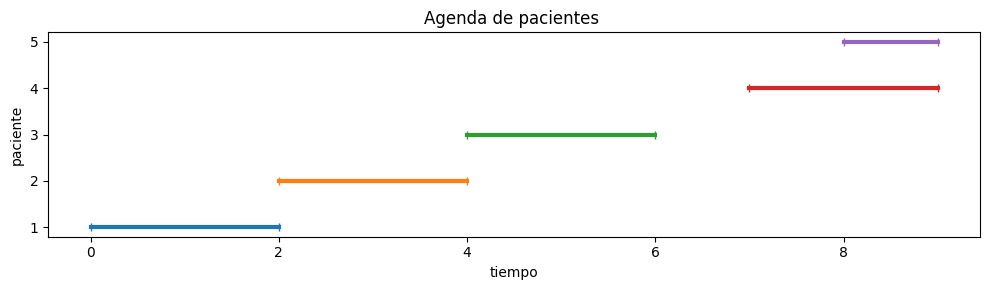

In [25]:
np.random.seed(20)
n_patients=5; n_enf=3
game = Game(n_patients, n_enf, p_short_stay=0.5, arrival_rate=4)
_=game.plot_pacientes()

# Validacion 1 - costos constantes

[1.4 0.  0. ]
[0.  2.8 0. ]
[0.  0.  4.2]


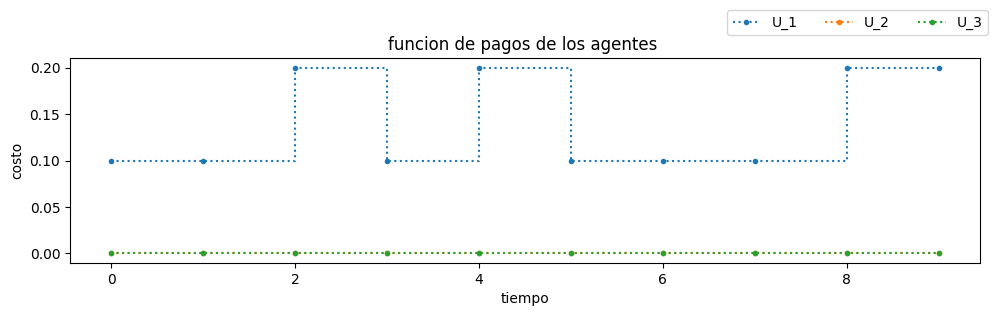

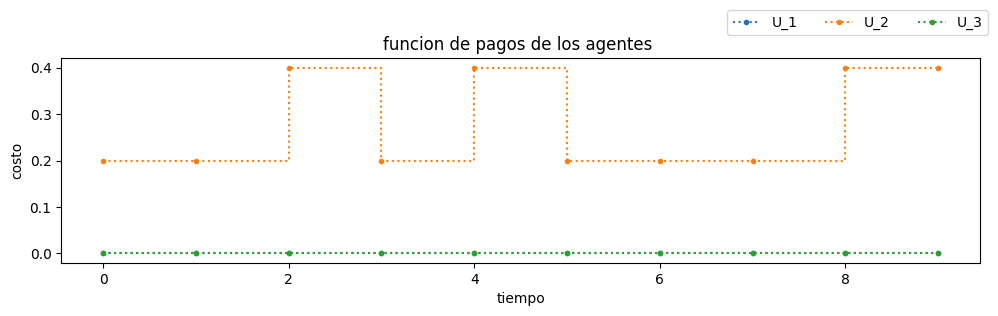

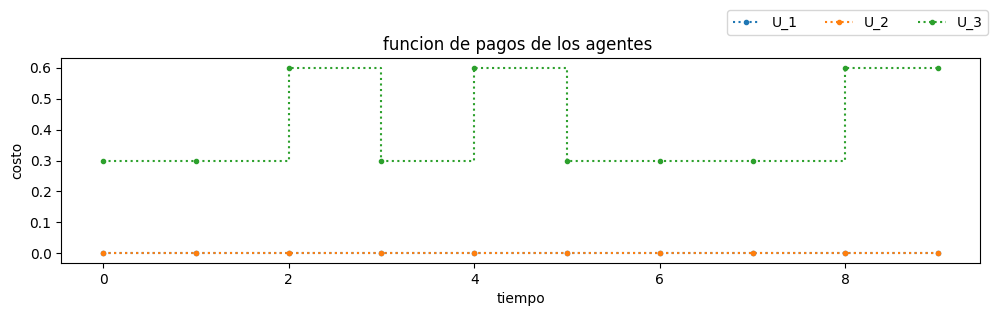

In [8]:
def always_i (enf, **kwargs):
    return enf, True

for enf in range(n_enf):
    u_0 = game.run_exp(funcion_acciones=partial(always_i, enf))
    _ = game.plot_pagos(u_0)
    print(u_0.sum(axis=0))

# sensibilidad 

In [9]:
import pandas as pd
from itertools import product  
from tqdm.notebook import tqdm
import scipy.stats as st


def run_strategy(strategy_function, strategy, result_row):
    '''recibe el array estrategia que indica que enfermero toma cada paciente
    guarda los resultados en results_row'''
    
    u_0=game.run_exp(funcion_acciones=partial(strategy_function, strategy))
    result_row['utilidad']=np.concatenate([game.summarize_utilities(u_0).flatten(), game.summarize_utilities(u_0).sum(axis=0)])
    return result_row

def create_results_table(exp_index, exp_values,runs):
    pagos_index=pd.MultiIndex.from_product([['utilidad'],['t%i'%i for i in range(n_patients)]+['total'],['U%i'%i for i in range(n_enf)]])
    resultados=pd.DataFrame(index=range(len(exp_values)), columns=exp_index.append(pagos_index)).sort_index()
    resultados['historia']=exp_values
    resultados=pd.concat([resultados]*runs, keys=range(runs)).sort_index()
    return resultados

def plot_aggregated_results(agg_, xlabel, title, alt_xticks=None):
    means=agg_.xs(('utilidad','total','mean'),level=[0,1,3],axis=1)
    intervals=agg_['utilidad','total'].groupby(level=0,axis=1).apply(lambda x: st.t.interval(0.9, 
                                                                                             x[x.name,'count']-1, 
                                                                                             x[x.name,'mean'], 
                                                                                             x[x.name,'sem']))
    fig, axs = plt.subplots(n_enf,1, sharex=True, figsize=(10,6))
    fig.suptitle(title)

    for i, ax in enumerate (axs):
        aux_df=means.iloc[:,i]#.sort_values(ascending=True)
        aux_df.plot(ax=ax, use_index=False)
        inf, up = intervals[i]
        ax.fill_between(np.arange(aux_df.shape[0]), inf[aux_df.index], up[aux_df.index],color='lightgrey')
        if i==0: ax.legend(['media', 'intervalo confianza - 90%'],ncol=2)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('costo U%i'%(1+i))
        
    if alt_xticks is not None: plt.xticks(np.arange(aux_df.shape[0]), alt_xticks)
    fig.tight_layout()
    return fig

## 1. Comparar todas las posibles estrategias puras variando los parametros que dominan la longitud de estadia, el tiempo entre llegadas y numero de pacientes

In [6]:
def pure_strategy (strategy, assignment, patient,**kwargs):
    try:
        enf=strategy[patient].index('A')
        return enf, True
    except ValueError:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False

pure_strategies=product(product(['A','R'],repeat=n_enf),repeat=n_patients)

In [7]:
runs=50
historia_index=pd.MultiIndex.from_product([['historia'],['t%i'%i for i in range(n_patients)],['S%i'%i for i in range(n_enf)]])
historia_values=np.array(list(pure_strategies)).reshape(-1,n_patients*n_enf)
resultados=create_results_table(historia_index, historia_values,runs)

for run in tqdm(resultados.index.get_level_values(0).unique()):
    resultados.loc[run]=resultados.loc[run].apply(lambda row: run_strategy(pure_strategy, row.historia, row), axis=1).values
    game.reset_patients()

  0%|          | 0/5 [00:00<?, ?it/s]

In [88]:
#resultados=pd.read_csv('results_data/puras_5p3f.zip', index_col=[0,1], header=[0,1,2], compression='zip')
resultados.to_csv(f'results_data/puras_5p3f.zip', compression=dict(method='zip', archive_name=f'puras_5p3f.csv'))
resultados.head()

historia                             ... utilidad                      \
          t0       t1       t2       t3  ...       t2   t3             t4   
          S0 S1 S2 S0 S1 S2 S0 S1 S2 S0  ...       U2   U0   U1   U2   U0   
0 0        A  A  A  A  A  A  A  A  A  A  ...      0.0  0.3  0.0  0.0  0.2   
  1        A  A  A  A  A  A  A  A  A  A  ...      0.0  0.3  0.0  0.0  0.2   
  2        A  A  A  A  A  A  A  A  A  A  ...      0.0  0.3  0.0  0.0  0.2   
  3        A  A  A  A  A  A  A  A  A  A  ...      0.0  0.3  0.0  0.0  0.2   
  4        A  A  A  A  A  A  A  A  A  A  ...      0.0  0.3  0.0  0.0  0.2   

                               
              total            
      U1   U2    U0   U1   U2  
0 0  0.0  0.0   1.1  0.0  0.0  
  1  0.0  0.0   1.1  0.0  0.0  
  2  0.0  0.0   1.1  0.0  0.0  
  3  0.0  0.0   1.1  0.0  0.0  
  4  0.0  0.0   1.1  0.0  0.0  

[5 rows x 33 columns]

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


utilidad                                                             ...  \
        t0                                                             ...   
        U0                               U1                   U2       ...   
     count   mean       sem       std count mean  sem  std count mean  ...   
0       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
1       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
2       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
3       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   
4       50  0.186  0.008576  0.060643    50  0.0  0.0  0.0    50  0.0  ...   

                                                                
      total                                                     
         U0             U1                   U2                 
        sem      std count mean  sem  std count mean  sem  std  
0  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
1  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
2  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
3  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  
4  0.016215  0.11466    50  0.0  0.0  0.0    50  0.0  0.0  0.0  

[5 rows x 72 columns]

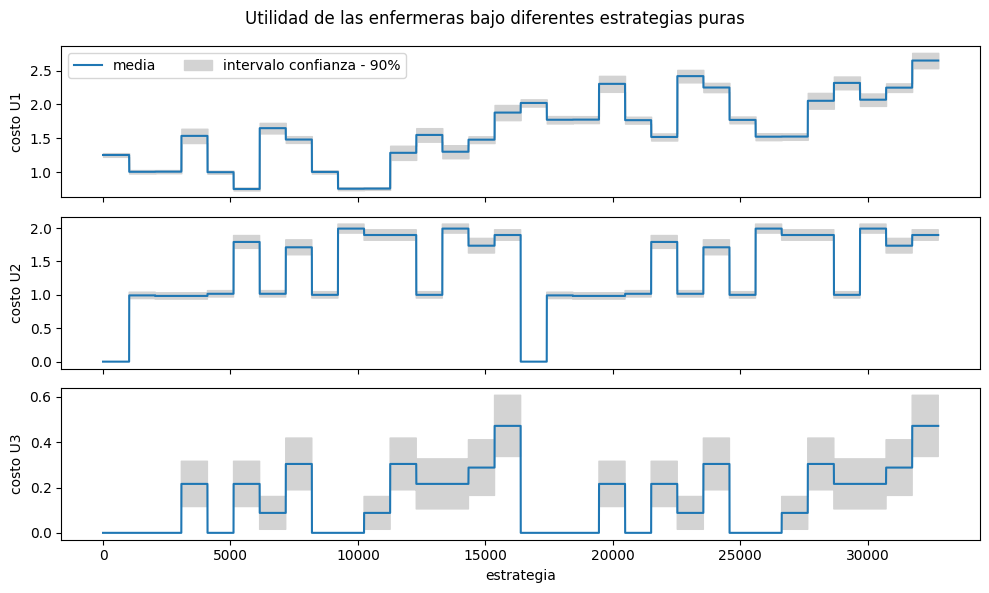

In [104]:
agg_=resultados[['utilidad']].groupby(level=1,axis=0).agg(["count","mean",st.sem,"std"])
fig = plot_aggregated_results(agg_, 'estrategia', 'Utilidad de las enfermeras bajo diferentes estrategias puras')
agg_.head()

## 1. Comparar estrategias mixtas

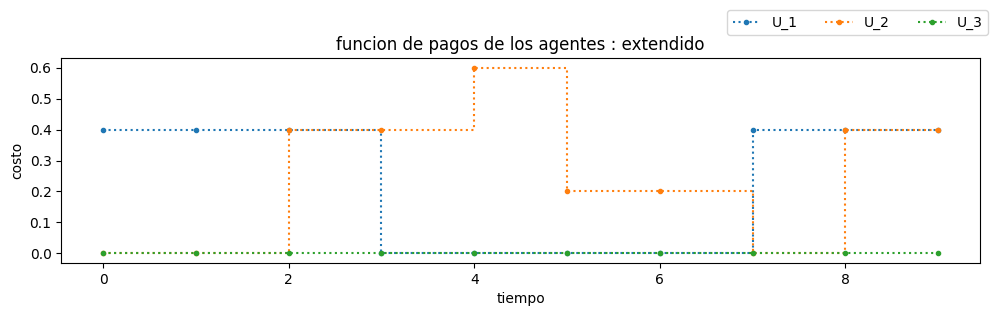

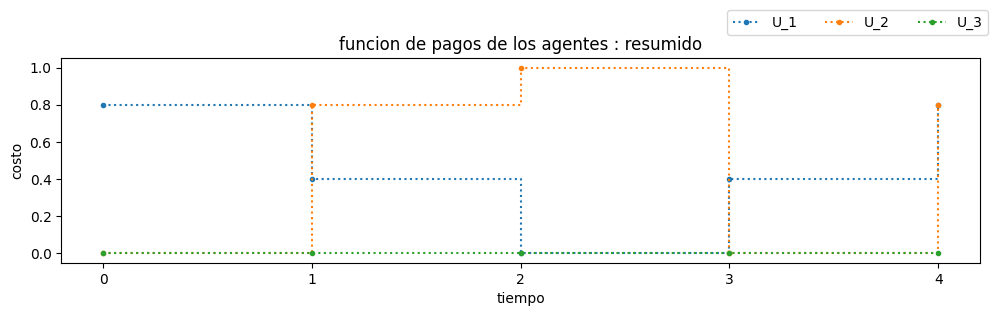

In [10]:
np.random.seed(None)
def mixed_strategies (p_aceptacion, assignment, n_enf, **kwargs):
    try:
        enf=np.random.choice(['acepta','rechaza'],p=[p_aceptacion,1-p_aceptacion],size=n_enf).tolist().index('acepta')
        return enf, True
    except ValueError:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False

p_aceptacion=0.1
u_0 = game.run_exp(funcion_acciones=partial(mixed_strategies,p_aceptacion))
_ = game.plot_pagos(u_0,': extendido')
_ = game.plot_pagos(game.summarize_utilities(u_0),': resumido')

In [28]:
runs=500
prob_index=pd.MultiIndex.from_arrays([['historia'],[''],['p']])
prob_values=np.linspace(0,1,11)
resultados=create_results_table(prob_index,prob_values,runs)

for run in tqdm(resultados.index.get_level_values(0).unique()):
    resultados.loc[run]=resultados.loc[run].apply(lambda row: run_strategy(mixed_strategies, row.historia.values[0], row), axis=1).values
    game.reset_patients()

resultados

  0%|          | 0/500 [00:00<?, ?it/s]

historia utilidad                                                    \
                      t0             t1             t2             t3        
              p       U0   U1   U2   U0   U1   U2   U0   U1   U2   U0   U1   
0   0       0.0      2.0  0.0  0.0  1.0  1.6  0.0  3.0  0.8  0.0  0.0  0.8   
    1       0.1      2.0  0.0  0.0  1.0  1.6  0.0  0.0  0.8  0.9  1.0  0.0   
    2       0.2      2.0  0.0  0.0  1.0  1.6  0.0  0.3  0.8  0.0  0.1  0.0   
    3       0.3      2.0  0.0  0.0  1.0  1.6  0.0  0.3  0.8  0.0  0.0  0.8   
    4       0.4      2.0  0.0  0.0  1.0  0.4  0.0  0.0  0.2  0.9  0.0  0.2   
...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
499 6       0.6      0.0  0.6  0.0  0.2  0.0  0.0  0.2  0.0  0.0  0.0  0.6   
    7       0.7      0.0  0.6  0.0  0.2  0.0  0.0  0.2  0.0  0.0  0.3  0.0   
    8       0.8      0.3  0.0  0.0  0.2  0.0  0.0  0.2  0.0  0.0  0.3  0.0   
    9       0.9      0.3  0.0  0.0  0.2  0.0  0.0  0.2  0.0  0.0  0.3  0.0   
    10      1.0      0.3  0.0  0.0  0.2  0.0  0.0  0.2  0.0  0.0  0.3  0.0   

                                            
              t4           total            
         U2   U0   U1   U2    U0   U1   U2  
0   0   0.0  2.0  1.6  0.0   8.0  4.8  0.0  
    1   0.0  2.0  1.6  0.0   6.0  4.0  0.9  
    2   0.0  0.2  1.6  0.0   3.6  4.0  0.0  
    3   0.0  0.2  1.6  0.0   3.5  4.8  0.0  
    4   0.0  0.2  0.4  0.0   3.2  1.2  0.9  
...     ...  ...  ...  ...   ...  ...  ...  
499 6   0.0  0.2  0.0  0.0   0.6  1.2  0.0  
    7   0.0  0.2  0.0  0.0   0.9  0.6  0.0  
    8   0.0  0.2  0.0  0.0   1.2  0.0  0.0  
    9   0.0  0.0  0.4  0.0   1.0  0.4  0.0  
    10  0.0  0.2  0.0  0.0   1.2  0.0  0.0  

[5500 rows x 19 columns]

In [15]:
#resultados=pd.read_csv('results_data/mixtas_5p3f.zip', index_col=[0,1], header=[0,1,2], compression='zip').head()
resultados.to_csv(f'results_data/mixtas_5p3f.zip', compression=dict(method='zip', archive_name=f'mixtas_5p3f.csv'))
resultados.head()

historia utilidad                                                         \
                   t0             t1             t2             t3             
           p       U0   U1   U2   U0   U1   U2   U0   U1   U2   U0   U1   U2   
0 0      0.0      0.4  0.0  0.0  0.4  0.4  0.0  0.4  0.8  1.2  0.8  0.0  0.0   
  1      0.1      0.4  0.0  0.0  0.4  0.4  0.0  0.4  0.8  1.2  0.8  0.0  0.0   
  2      0.2      0.0  0.0  0.3  0.4  0.0  0.3  0.8  0.6  0.3  0.0  0.0  0.6   
  3      0.3      0.0  0.2  0.0  0.1  0.2  0.0  0.5  0.2  0.0  0.2  0.0  0.0   
  4      0.4      0.4  0.0  0.0  0.5  0.0  0.0  0.9  0.0  0.0  0.2  0.0  0.0   

                                    
      t4           total            
      U0   U1   U2    U0   U1   U2  
0 0  0.0  1.2  0.0   2.0  2.4  1.2  
  1  0.0  1.2  0.0   2.0  2.4  1.2  
  2  0.0  0.0  0.9   1.2  0.6  2.4  
  3  0.3  0.0  0.0   1.1  0.6  0.0  
  4  0.0  1.2  0.0   2.0  1.2  0.0

c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


utilidad                                                                \
        t0                                                                 
        U0                                U1                               
     count    mean       sem       std count    mean       sem       std   
0      500  1.7060  0.030347  0.678590   500  0.0000  0.000000  0.000000   
1      500  1.2326  0.041862  0.936071   500  0.0348  0.005063  0.113202   
2      500  0.8756  0.041933  0.937658   500  0.0532  0.006146  0.137432   
3      500  0.6476  0.038952  0.870983   500  0.0684  0.006706  0.149955   
4      500  0.5250  0.035515  0.794139   500  0.0744  0.006990  0.156312   

                 ...                                                        \
                 ...     total                                               
     U2          ...        U0              U1                               
  count    mean  ...       sem       std count    mean       sem       std   
0   500  0.0000  ...  0.052004  1.162836   500  3.7536  0.033233  0.743123   
1   500  0.0396  ...  0.078705  1.759902   500  3.0252  0.051055  1.141636   
2   500  0.0624  ...  0.079317  1.773588   500  2.3804  0.057886  1.294360   
3   500  0.0702  ...  0.076997  1.721705   500  1.8964  0.052063  1.164155   
4   500  0.0672  ...  0.069379  1.551358   500  1.4796  0.046663  1.043418   

                                     
                                     
     U2                              
  count    mean       sem       std  
0   500  0.6672  0.035221  0.787556  
1   500  0.6834  0.032356  0.723513  
2   500  0.7260  0.033450  0.747959  
3   500  0.6798  0.030172  0.674657  
4   500  0.6084  0.030088  0.672781  

[5 rows x 72 columns]

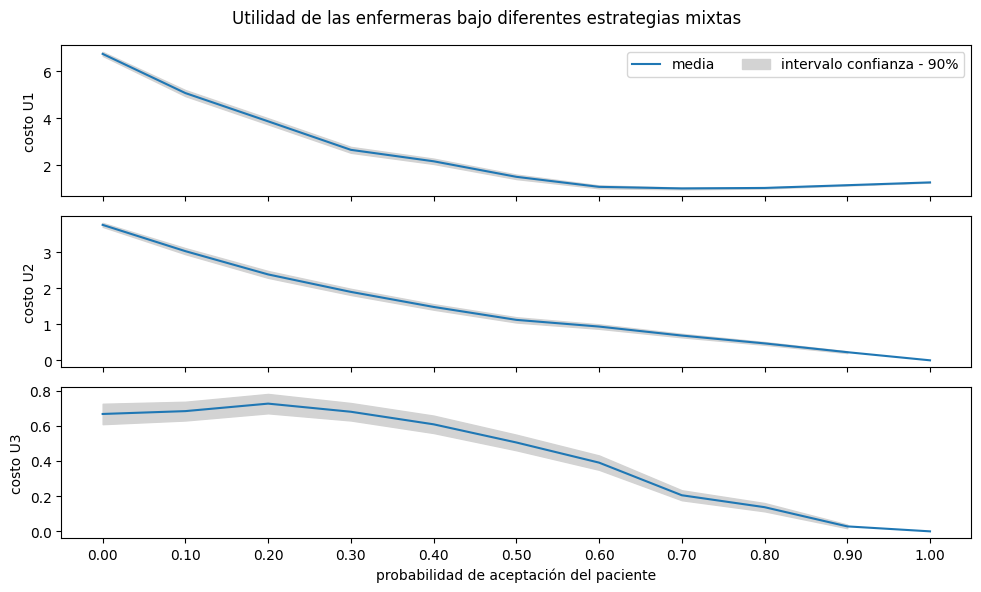

In [29]:
agg_=resultados[['utilidad']].groupby(level=1,axis=0).agg(["count","mean",st.sem,"std"])
fig = plot_aggregated_results(agg_, 'probabilidad de aceptación del paciente', 'Utilidad de las enfermeras bajo diferentes estrategias mixtas',
                              alt_xticks=['%.2f'%p for p in prob_values])
agg_.head()

### * Incluir variaciones en los vectores de costo y penalización

In [ ]:
game.fix_utilities = lambda u_time,u_penal: u_time * game.experience_weight + u_penal * game.experience_weight[::-1]*3

# 3. validacion 2: rechazo constante de un enfermero

In [24]:
def never_i (enf, assignment, n_enf, **kwargs):
    enf = np.random.choice([i for i in range(-1,n_enf) if i != enf])
    if enf==-1:
        enf=assignment.astype(bool).sum(axis=1).argmin()
        return enf, False
    else: return enf, True

runs=500
prob_index=pd.MultiIndex.from_arrays([['historia'],[''],['enfermera']])
prob_values=range(n_enf)
resultados=create_results_table(prob_index,prob_values,runs)

for run in tqdm(resultados.index.get_level_values(0).unique()):
    resultados.loc[run]=resultados.loc[run].apply(lambda row: run_strategy(never_i, row.historia.values[0], row), axis=1).values
    game.reset_patients()

resultados

  0%|          | 0/500 [00:00<?, ?it/s]

historia utilidad                                                    \
                      t0             t1             t2             t3        
      enfermera       U0   U1   U2   U0   U1   U2   U0   U1   U2   U0   U1   
0   0       0.0      0.0  0.2  0.0  0.4  0.2  0.0  0.4  0.8  0.0  0.0  0.0   
    1       1.0      0.1  0.0  0.0  0.1  0.4  0.0  0.1  0.4  1.2  0.0  0.0   
    2       2.0      0.1  0.0  0.0  0.2  0.0  0.0  0.2  1.2  0.0  0.8  0.0   
1   0       0.0      0.0  0.0  0.6  0.0  0.4  0.3  0.0  0.6  0.0  0.0  0.0   
    1       1.0      0.0  0.0  0.6  0.2  0.0  0.3  0.0  0.0  0.9  0.0  0.0   
...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
498 1       1.0      0.1  0.0  0.0  0.2  0.0  0.6  0.2  0.0  0.3  0.0  0.0   
    2       2.0      0.0  0.2  0.0  0.0  0.8  0.0  0.8  0.2  0.0  0.3  0.0   
499 0       0.0      0.0  0.0  0.6  0.0  0.6  0.3  0.8  0.0  0.0  0.0  0.0   
    1       1.0      0.8  0.0  0.0  0.7  0.0  0.0  0.2  0.0  0.0  0.2  0.0   
    2       2.0      0.8  0.0  0.0  0.4  0.6  0.0  0.0  0.4  0.0  0.2  0.0   

                                           
             t4           total            
        U2   U0   U1   U2    U0   U1   U2  
0   0  0.6  0.0  0.4  0.0   0.8  1.6  0.6  
    1  0.6  0.2  0.0  0.0   0.5  0.8  1.8  
    2  0.0  0.2  0.0  0.0   1.5  1.2  0.0  
1   0  0.9  0.8  0.0  0.0   0.8  1.0  1.8  
    1  0.9  0.0  0.0  0.6   0.2  0.0  3.3  
...    ...  ...  ...  ...   ...  ...  ...  
498 1  0.9  0.0  0.0  0.6   0.5  0.0  2.4  
    2  0.0  0.2  0.0  0.0   1.3  1.2  0.0  
499 0  0.6  0.8  0.0  0.0   1.6  0.6  1.5  
    1  0.0  0.2  0.0  0.0   2.1  0.0  0.0  
    2  0.0  0.0  0.4  0.0   1.4  1.4  0.0  

[1500 rows x 19 columns]

utilidad                                                                \
        t0                                                                 
        U0                                U1                               
     count    mean       sem       std count    mean       sem       std   
0      500  0.2360  0.016155  0.361227   500  0.1148  0.007767  0.173670   
1      500  0.2842  0.014818  0.331346   500  0.0000  0.000000  0.000000   
2      500  0.2848  0.015044  0.336386   500  0.1080  0.007683  0.171799   

                 ...                                                        \
                 ...     total                                               
     U2          ...        U0              U1                               
  count    mean  ...       sem       std count    mean       sem       std   
0   500  0.1542  ...  0.033331  0.745296   500  1.1616  0.027161  0.607341   
1   500  0.1656  ...  0.029049  0.649549   500  0.7176  0.031033  0.693926   
2   500  0.0000  ...  0.027379  0.612220   500  1.4708  0.025413  0.568255   

                                     
                                     
     U2                              
  count    mean       sem       std  
0   500  1.2932  0.035835  0.801298  
1   500  1.2946  0.037249  0.832910  
2   500  0.0808  0.012370  0.276594  

[3 rows x 72 columns]

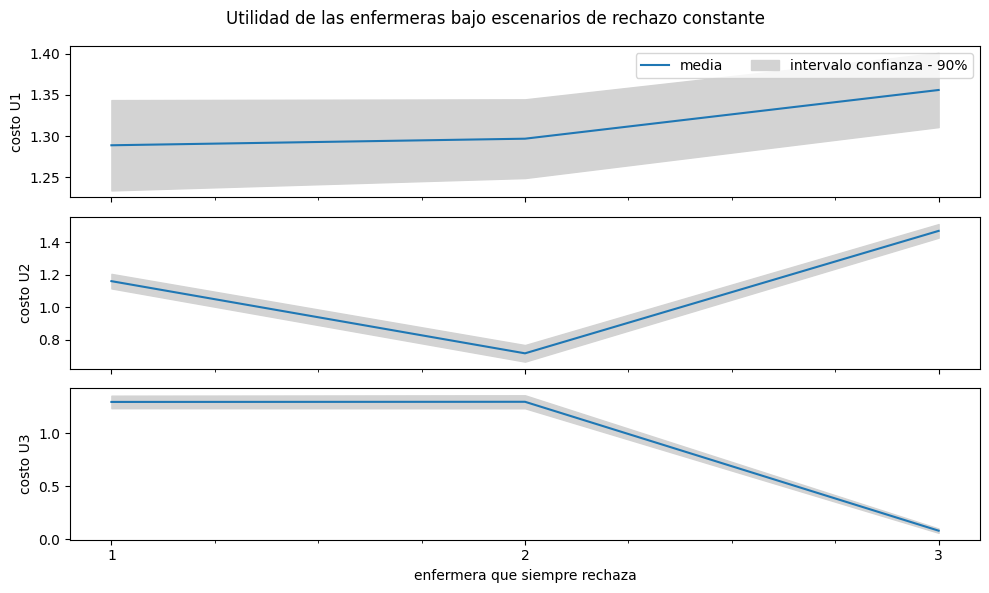

In [25]:
agg_=resultados[['utilidad']].groupby(level=1,axis=0).agg(["count","mean",st.sem,"std"])
fig = plot_aggregated_results(agg_, 'enfermera que siempre rechaza', 'Utilidad de las enfermeras bajo escenarios de rechazo constante',
                              alt_xticks=range(1,1+n_enf))
agg_.head()